## Metadata Profiling

In [1]:
from library.profiler import call_profiler
import os
import torch

In [2]:
# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
original_metadata_path = os.getcwd() + "/assets/911_metadata.csv"
calls_folder_path = os.getcwd()+ "/assets/calls"
transcripts_folder_path = os.getcwd() + "/assets/transcriptions"
logs_folder_path = os.getcwd() + "/assets/call_based_logs"
cores = 6

In [4]:
generated_metadata = call_profiler.CallProfiler()

generated_metadata.profile_calls(
    original_metadata_file = original_metadata_path,
    calls_folder_path= calls_folder_path,
    transcripts_folder_path = transcripts_folder_path ,
    logs_folder_path=logs_folder_path,
    generate_csv=False,
    log_level="high",
    cores=cores,
    persistent_mode=True)

call_metadata_df = generated_metadata.get_data()

Starting profiling in folder: /root/git/Project/assets/calls using 6 core(s). Persistent mode: True
Loading existing metadata from /root/git/Project/assets/call_metadata/persistent_call_data.csv
Found 0 new files to process.
Persistent CSV saved at /root/git/Project/assets/call_metadata/persistent_call_data.csv
Profiling complete. DataFrame updated.


In [5]:
call_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   file_name                22 non-null     object 
 1   format                   22 non-null     object 
 2   length_seconds           22 non-null     float64
 3   transcription_available  22 non-null     bool   
 4   log_available            22 non-null     bool   
 5   category                 22 non-null     object 
 6   description              20 non-null     object 
dtypes: bool(2), float64(1), object(4)
memory usage: 1.0+ KB


In [6]:
call_metadata_df

,file_name,format,length_seconds,transcription_available,log_available,category,description
0,call_66.mp3,mp3,158.544,True,False,California,– calls made after two small Cessna airplanes ...
1,call_42.mp3,mp3,325.944,True,False,Colorado,NaN
2,call_115.mp3,mp3,102.400,True,False,Arizona,– In Feb. 2011 a trio of dogs escaped from a y...
3,call_105.mp3,mp3,222.399,True,False,Wisconsin,– In Dec. 2010 a Green Lake County (Wisc.) cou...
4,call_147.mp3,mp3,247.275,True,False,Oklahoma,– In May 2011 a college football player on pai...
5,call_187.mp3,mp3,243.069,True,False,Louisiana,– In Dec. 2011 a woman drove the wrong way on ...
6,call_247.mp3,mp3,137.012,True,False,Connecticut,– In June 2012 a man in East Hartford (Conn.) ...
7,call_358.mp3,mp3,128.575,True,False,Wisconsin,NaN
8,call_400.mp3,mp3,91.899,True,False,Massachusetts,– In Sept. 2008 someone left a small baby on t...
9,call_483.mp3,mp3,105.264,True,False,Kansas,– In Dec. 2008 10 year-old Anthony Akins-Bomho...


## Transcription and Diarization

In [ ]:
call_metadata_df[call_metadata_df["transcription_available"] == True ]

In [7]:
from library.transcriber_diarizer import transcriber_diarizer
from whisper import load_model



In [ ]:

# Load Whisper model once
whisper_model = load_model("large" , device=device)

In [ ]:
transcriber_diarizer = transcriber_diarizer.CallTranscriberDiarizer(
    
    audio_path=calls_folder_path,
    transcription_path=transcripts_folder_path,
    whisper_model=whisper_model,
    language="english",
    wav_conversion=True
)

In [ ]:
transcriber_diarizer.process_transcriptions_and_diarizations(call_metadata_df=call_metadata_df,cores=cores)

In [ ]:
generated_metadata.update(call_metadata_df=call_metadata_df)

In [12]:
del( whisper_model)
torch.cuda.empty_cache()

## Event Labeling

In [7]:
from library.event_classifier import event_classifier_llama
from transformers import AutoTokenizer, AutoModelForCausalLM

llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
llama_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")


if llama_tokenizer.pad_token is None:
    llama_tokenizer.pad_token = llama_tokenizer.eos_token  # Use eos_token as pad_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
call_metadata_df[call_metadata_df["log_available"]==True]

,file_name,format,length_seconds,transcription_available,log_available,category,description


In [9]:
classifier = event_classifier_llama.LlamaEventClassifier(
    model=llama_model,
    tokenizer=llama_tokenizer,
    device=device,
    context_length=3,
    metadata_df=call_metadata_df,
    transcription_path=transcripts_folder_path,
    logs_folder_path=logs_folder_path,
    cores=cores  # Number of workers (might be overkill for a single file, can set lower)
)

2025-01-13 23:34:08,775 - INFO - LlamaEventClassifier initialized.


In [10]:
# Process files
classifier.process_all_files()

2025-01-13 23:34:13,429 - INFO - Starting processing for 22 files.
2025-01-13 23:48:20,779 - INFO - Completed processing for all files.


In [ ]:
generated_metadata.update(call_metadata_df=call_metadata_df)

,file_name,format,length_seconds,transcription_available,log_available,category,description
0,call_66.mp3,mp3,158.544,True,True,California,– calls made after two small Cessna airplanes ...
1,call_42.mp3,mp3,325.944,True,True,Colorado,NaN
2,call_115.mp3,mp3,102.400,True,True,Arizona,– In Feb. 2011 a trio of dogs escaped from a y...
3,call_105.mp3,mp3,222.399,True,True,Wisconsin,– In Dec. 2010 a Green Lake County (Wisc.) cou...
4,call_147.mp3,mp3,247.275,True,True,Oklahoma,– In May 2011 a college football player on pai...
5,call_187.mp3,mp3,243.069,True,True,Louisiana,– In Dec. 2011 a woman drove the wrong way on ...
6,call_247.mp3,mp3,137.012,True,True,Connecticut,– In June 2012 a man in East Hartford (Conn.) ...
7,call_358.mp3,mp3,128.575,True,True,Wisconsin,NaN
8,call_400.mp3,mp3,91.899,True,True,Massachusetts,– In Sept. 2008 someone left a small baby on t...
9,call_483.mp3,mp3,105.264,True,True,Kansas,– In Dec. 2008 10 year-old Anthony Akins-Bomho...


## Process Mining 

In [12]:
from library.pm_processor import pm_processor
import pm4py

In [13]:
# Initialize PMProcessor with metadata and logs folder path
pm_processor = pm_processor.PMProcessor(metadata_df = call_metadata_df,
                                         logs_folder_path=logs_folder_path)

In [14]:
# Process logs using the PMProcessor
combined_logs = pm_processor.process_logs()

In [15]:
combined_logs

,start_timestamp,end_timestamp,Text,Speaker,file_name,event,case_id
0,2024-01-01 00:00:04.840,2024-01-01 00:00:06.520,"9-1-1, we're going to be fine.",Speaker 0,call_66.mp3,Call Deposition,call_66.mp3
1,2024-01-01 00:00:06.720,2024-01-01 00:00:10.740,An airplane just went down off of in Corona.,Speaker 0,call_66.mp3,Description,call_66.mp3
2,2024-01-01 00:00:11.020,2024-01-01 00:00:13.760,An airplane went down? Where did it go down at?,Speaker 0,call_66.mp3,Description,call_66.mp3
3,2024-01-01 00:00:13.920,2024-01-01 00:00:17.480,It's like right where the Chevy dealership is...,Speaker 0,call_66.mp3,Description,call_66.mp3
4,2024-01-01 00:00:17.960,2024-01-01 00:00:18.740,At Surface?,Speaker 0,call_66.mp3,Description,call_66.mp3
...,...,...,...,...,...,...,...
1460,2024-01-01 00:03:58.780,2024-01-01 00:03:58.780,NaN,Unknown,call_16.mp3,No Voice Detected,call_16.mp3
1461,2024-01-01 00:03:58.780,2024-01-01 00:03:58.780,NaN,Unknown,call_16.mp3,No Voice Detected,call_16.mp3
1462,2024-01-01 00:03:59.760,2024-01-01 00:04:02.500,"Okay, sir. Central PD and the medics are on t...",Unknown,call_16.mp3,Resolution,call_16.mp3
1463,2024-01-01 00:04:03.020,2024-01-01 00:04:03.940,"Okay, thank you.",Unknown,call_16.mp3,Call Deposition,call_16.mp3


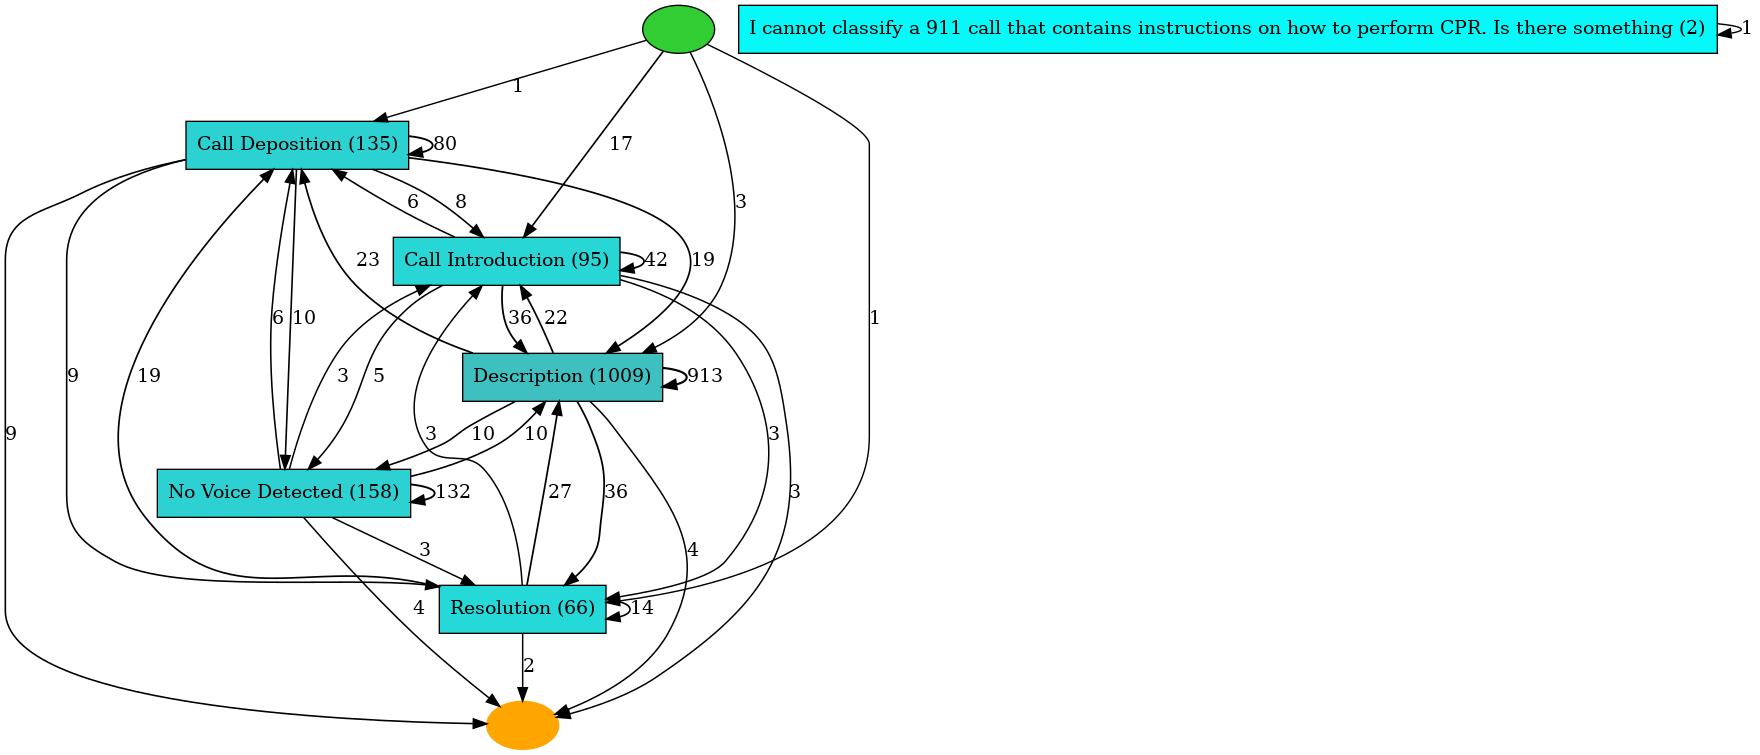

In [16]:

#event_log = log_converter.apply(df)
map = pm4py.discover_heuristics_net(log = combined_logs,
                                    case_id_key="case_id",
                                    activity_key="event",
                                    timestamp_key="start_timestamp")
pm4py.view_heuristics_net(map)